In [ ]:
!pip install datasets
!pip install diffusers
!pip install accelerate
!pip install --upgrade torchmetrics[image]
!pip install --upgrade torch-fidelity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 6.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-ma

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torchvision
import math
import os

from torchvision import transforms
from datasets import load_dataset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

import torch.nn.functional as F
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
from diffusers import DDPMPipeline
from diffusers.optimization import get_cosine_schedule_with_warmup
from datasets import load_dataset
from dataclasses import dataclass
from PIL import Image

from accelerate import Accelerator
from tqdm.auto import tqdm
from pathlib import Path
import os

from accelerate import notebook_launcher

import glob

import os

from PIL import Image
import numpy as np

from diffusers import DDPMPipeline

import torch
from torchvision import transforms
from PIL import Image

from torchmetrics.image.fid import FrechetInceptionDistance

from shutil import copyfile

import matplotlib.pyplot as plt

from diffusers import DiTPipeline, DPMSolverMultistepScheduler

from datasets import load_dataset

In [ ]:
#class for adjusting training hyperparameters


@dataclass
class TrainingConfig:
    image_size = 64  # the generated image resolution, not sure what image size to use.
    train_batch_size = 64
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 200
    gradient_accumulation_steps = 1
    learning_rate = 1e-3
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 20
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "/content/drive/MyDrive/AML_course_work_butterfly/lr_1e-4"  # directory to save the output on drive
    push_to_hub = False

    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 42
    losses = []

config = TrainingConfig()

In [ ]:
#Getting dataset from hugging face

config.dataset_name = "huggan/smithsonian_butterflies_subset"

full_train_dataset = load_dataset(config.dataset_name, split="train")

# Split the dataset into train and test sets

split_ratio = 0.95
split = full_train_dataset.train_test_split(test_size=1 - split_ratio)

dataset = split['train']
dataset_test = split['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

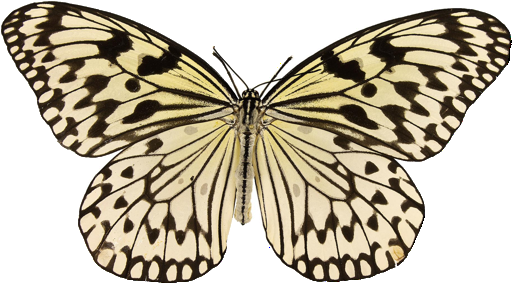

In [ ]:
#Visualizing first image in whole dataset

full_train_dataset["image"][0]

In [ ]:
# Path to your dataset directory
dataset_dir = "/content/butterflies_dataset"

# Path to where you want to save the train and test datasets
train_dir = "/content/train"
test_dir = "/content/test"

#create dataset  directory if doesn't exists
os.makedirs(dataset_dir, exist_ok=True)

#saving full dataset images

i = 0
for im in full_train_dataset["image"]:
  im.save(os.path.join(dataset_dir,"image"+str(i)+".png"))
  i = i + 1


In [ ]:
# Create train and test directories if they don't exist

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

#saving images in train dataset

i = 0
for im in dataset["image"]:
  im.save(os.path.join(train_dir,"image"+str(i)+".png"))
  i = i + 1

#saving images in test dataset

i = 0
for im in dataset_test["image"]:
  im.save(os.path.join(test_dir,"image"+str(i)+".png"))
  i = i + 1



In [ ]:
# train_dataset
dataset

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 949
})

949
51


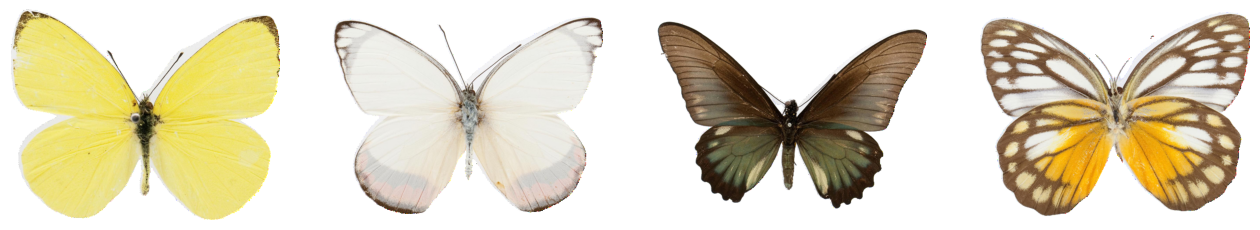

In [ ]:
#visualizing first 4 images in train dataset

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()

print(len(dataset))
print(len(dataset_test))

In [ ]:
#building transforms to be used on datset

preprocess=transforms.Compose([
        transforms.Resize((config.image_size, config.image_size)),  # Resize
        transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1) # Note that the model expexts this distribution
    ])

In [ ]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform) # This will apply the preprocess function of the fly during the training

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

In [ ]:
#printing first batch

for batch in train_dataloader:
    print(batch)
    break  # Print only the first batch for brevity


{'images': tensor([[[[ 1.0000,  1.0000,  0.9765,  ...,  0.7255,  0.8824,  1.0000],
          [ 1.0000,  0.9529,  0.6471,  ..., -0.1765,  0.1216,  0.8431],
          [ 1.0000,  0.7333, -0.1137,  ..., -0.3569, -0.2941,  0.4039],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  0.9922,  ...,  0.6863,  0.8667,  1.0000],
          [ 1.0000,  0.9451,  0.6000,  ..., -0.3647, -0.0353,  0.7961],
          [ 0.9922,  0.6941, -0.2941,  ..., -0.5608, -0.4980,  0.2549],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  0.9922,  ...,  0.6549,  0.8588,  1.0000],
          [ 1.0000,

In [ ]:
# the model from hugging face

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [ ]:
#Printing input shape

sample_image = dataset[0]["images"].unsqueeze(0)
print("Input shape:", sample_image.shape) #To make sure that the sample image shape matches the modal output shape

Input shape: torch.Size([1, 3, 64, 64])


In [ ]:
#Printing output shape

print("Output shape:", model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 64, 64])


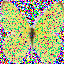

In [ ]:
# During training, the schedular tajes a model's output and applies noise to the image
# During inference, the scheduler generates image from the noise

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [ ]:
# The objective of the model is to pridict the noise added to the image.

noise_pred = model(noisy_image, timesteps).sample

#Defining loss function

loss = F.mse_loss(noise_pred, noise)

In [ ]:
#Defining optimizer and noise scheduler

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [ ]:
#making grid to visualize output images from the model

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid

#model evaluation

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process)
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [ ]:
def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

#model training

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch["images"]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir)

In [ ]:

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
# Display the sample images saved during the training

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(config.losses)

In [ ]:
#checking cuda is working

device="cuda" if torch.cuda.is_available() else "cpu"

#constructing pipeline from unet and noise scheduler

pipe= DDPMPipeline(unet=model,scheduler=noise_scheduler)
pipe.to(device)

In [ ]:
pipe().images[0]

In [ ]:
pipe = DDPMPipeline.from_pretrained(config.output_dir)

In [ ]:

images = pipe(
        batch_size=3,
        generator=torch.manual_seed(config.seed),
    ).images
test_dir = os.path.join("generated_images", "samples")
os.makedirs(test_dir, exist_ok=True)
for i,image in enumerate(images):
    image.save(f"{test_dir}/{i:04d}.png")



In [ ]:
dataset_path = "/content/test"
image_paths = sorted([os.path.join(dataset_path, x) for x in os.listdir(dataset_path)])

real_images = [np.array(Image.open(path).convert("RGB")) for path in image_paths]

In [ ]:
from torchvision.transforms import functional as F


def preprocess_image(image):
    image = torch.tensor(image).unsqueeze(0)
    image = image.permute(0, 3, 1, 2) / 255.0
    return F.center_crop(image, (256, 256))

real_images = torch.cat([preprocess_image(image) for image in real_images])
print(real_images.shape)

In [ ]:
#generaing fake images with considerable amount compared to test images

fake_images = pipe(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images


In [ ]:
# Define transformations

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to a fixed size
    transforms.ToTensor(),           # Convert image to PyTorch tensor
])

# Apply transformations to each image in the list

fake_images_tensor = torch.stack([transform(img) for img in fake_images])

print(fake_images_tensor.shape)


In [ ]:
fake_images = fake_images_tensor
print(fake_images.shape)

In [ ]:
#Computing FID score wich is a measure of how well the generated images are compared to real images

fid = FrechetInceptionDistance(normalize=True)
fid.update(real_images, real=True)
fid.update(fake_images, real=False)

print(f"FID: {float(fid.compute())}")